# Loading models and extracting reps

In [ ]:
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2Config, HubertModel, HubertConfig, AutoFeatureExtractor
import soundfile as sf
import torch

In [ ]:
import os
def extract_reps(model_name, model, feat_extractor, model_config):
    # Initializing the model configuration
    configuration = model_config().from_pretrained(model_name, output_hidden_states=True)
    # Initialize the model
    model = model(configuration)

    # Initialize the feature extractor
    feature_extractor = feat_extractor.from_pretrained(model_name)

    # List to store hidden state representations for each layer
    all_hidden_states = []
    data_dir = "Speech_folder/"
    # Iterate over all audio files in the dataset directory
    for root, _, files in os.walk(data_dir):
        for filename in files:
            if filename.endswith(".flac"):  # Assuming audio files are in FLAC format
                audio_path = os.path.join(root, filename)
                # Read audio file
                audio, _ = sf.read(audio_path)

                # Extract features
                inputs = feature_extractor(audio, return_tensors="pt", sampling_rate=16000)

                # Extract hidden states
                with torch.no_grad():
                    outputs = model(inputs.input_values)

                # Get hidden states for each layer and append them to the list
                hidden_states = outputs.hidden_states
                all_hidden_states.append(hidden_states)

    return all_hidden_states

In [ ]:
hubertB = "facebook/hubert-base-ls960"
hubertL = "facebook/hubert-large-ll60k"
wav2vec2_B = "facebook/wav2vec2-base-960h"
wav2vec2_L = "facebook/wav2vec2-large-960h"
xlsr_L = "jonatasgrosman/wav2vec2-large-xlsr-53-english"

In [ ]:
wav2vec2_base_hs = extract_reps(wav2vec2_B, Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2Config)
wav2vec2_large_hs = extract_reps(wav2vec2_L, Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2Config)
xlsr_large_hs = extract_reps(xlsr_L, Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2Config)
hubert_base_hs = extract_reps(hubertB, HubertModel, AutoFeatureExtractor, HubertConfig)
hubert_large_hs = extract_reps(hubertL, HubertModel, AutoFeatureExtractor, HubertConfig)

In [ ]:
len(wav2vec2_base_hs[0]) #(number_of_audio_files)x13x1x(frame_lengthx768)

# Computing similarities

## CKA similarity

In [ ]:
import math
import numpy as np


def centering(K):
    n = K.shape[0]
    unit = np.ones([n, n])
    I = np.eye(n)
    H = I - unit / n

    return np.dot(np.dot(H, K), H)  # HKH are the same with KH, KH is the first centering, H(KH) do the second time, results are the sme with one time centering
    # return np.dot(H, K)  # KH


def rbf(X, sigma=None):
    GX = np.dot(X, X.T)
    KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
    if sigma is None:
        mdist = np.median(KX[KX != 0])
        sigma = math.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = np.exp(KX)
    return KX


def kernel_HSIC(X, Y, sigma):
    return np.sum(centering(rbf(X, sigma)) * centering(rbf(Y, sigma)))


def linear_HSIC(X, Y):
    L_X = np.dot(X, X.T)
    L_Y = np.dot(Y, Y.T)
    return np.sum(centering(L_X) * centering(L_Y))


def linear_CKA(X, Y):
    hsic = linear_HSIC(X, Y)
    var1 = np.sqrt(linear_HSIC(X, X))
    var2 = np.sqrt(linear_HSIC(Y, Y))

    return hsic / (var1 * var2)


def kernel_CKA(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = np.sqrt(kernel_HSIC(X, X, sigma))
    var2 = np.sqrt(kernel_HSIC(Y, Y, sigma))

    return hsic / (var1 * var2)

In [ ]:
def calculate_cka_similarity(rep1, rep2):
    num_layers1 = len(rep1) - 1
    num_layers2 = len(rep2) - 1
    # Initialize a 2D matrix to store CKA values
    cka_matrix = np.zeros((num_layers1, num_layers2))

    for i in range(num_layers1):
      for j in range(num_layers2):
        reps1 = rep1[i].squeeze(0)
        reps2 = rep2[j].squeeze(0)

        cka_value = kernel_CKA(reps1, reps2)

        cka_matrix[i, j] = cka_value

    return cka_matrix

In [ ]:
def average_cka_similarity(wav2vec2_base_hs, hubert_large_hs):
    naudio = len(wav2vec2_base_hs)
    num_layers1 = len(wav2vec2_base_hs[0]) - 1
    num_layers2 = len(hubert_large_hs[0]) - 1
    sum_mat = np.zeros((num_layers1, num_layers2))
    for i in range(naudio):
      temp_mat = calculate_cka_similarity(wav2vec2_base_hs[i], hubert_large_hs[i])
      sum_mat += temp_mat
    return sum_mat/naudio

In [ ]:
wavB_cka = average_cka_similarity(wav2vec2_base_hs, hubert_large_hs)
wavL_cka = calculate_cka_similarity(wav2vec2_large_hs, hubert_large_hs)
XLSR_cka = calculate_cka_similarity(xlsr_large_hs, hubert_large_hs)
HubertB_cka = calculate_cka_similarity(hubert_base_hs, hubert_large_hs)

In [ ]:
wavB_cka.shape

(12, 24)

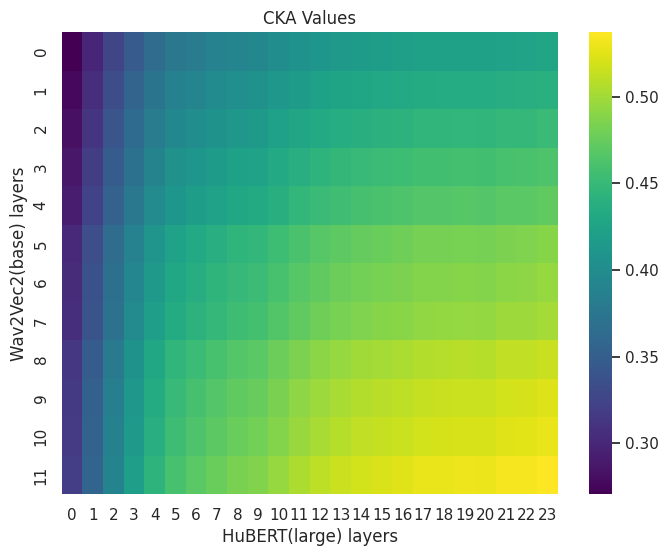

In [ ]:
plot_heatmap(wavB_cka, "CKA Values", "Wav2Vec2(base) layers")

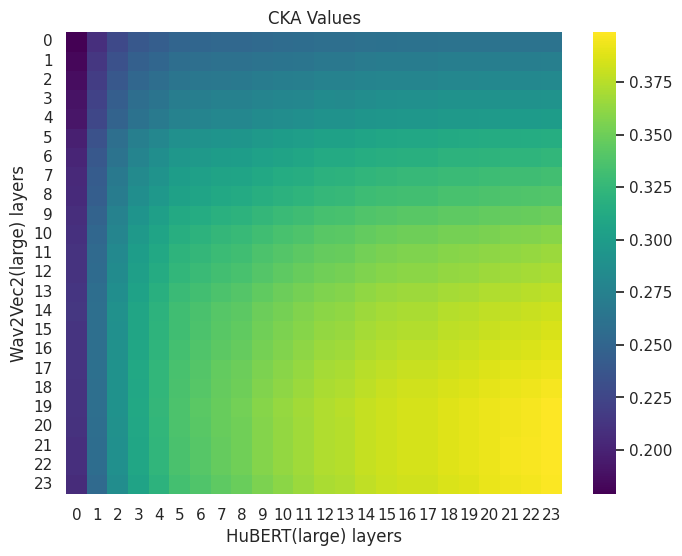

In [ ]:
plot_heatmap(wavL_cka, "CKA Values", "Wav2Vec2(large) layers")

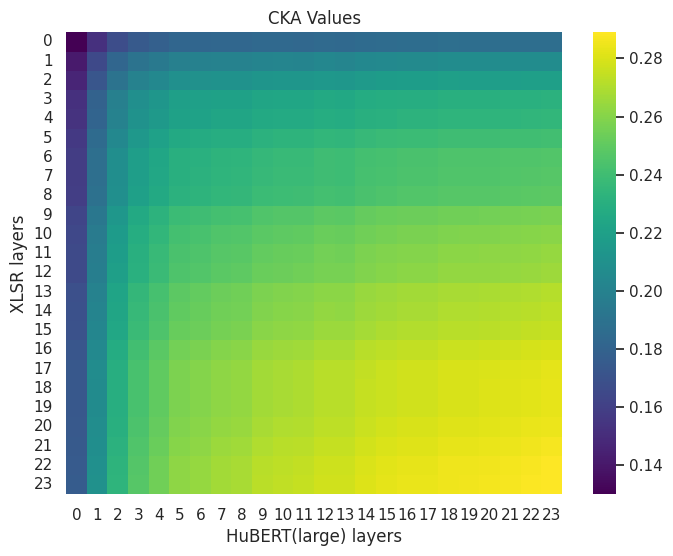

In [ ]:
plot_heatmap(XLSR_cka, "CKA Values", "XLSR layers")

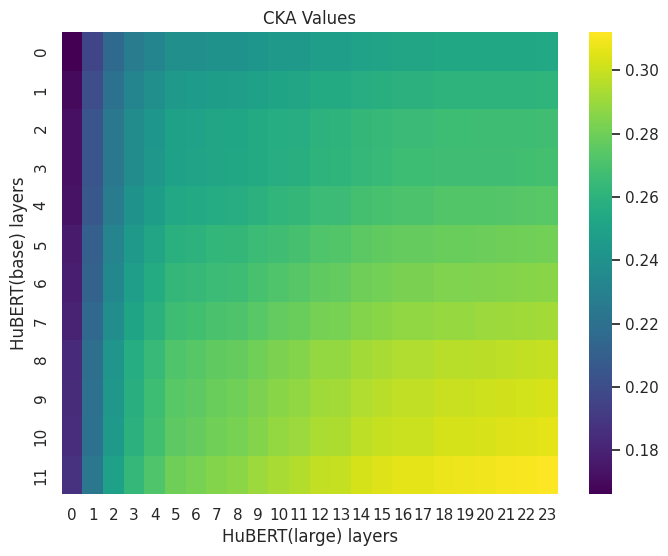

In [ ]:
plot_heatmap(HubertB_cka, "CKA Values", "HuBERT(base) layers")